# Premier League Match Outcome Predictor

In [1]:
# Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
df = pd.read_csv("premier_league_2023_2025.csv")  # replace with your CSV
df.head()

,home_team,away_team,home_goals,away_goals,result,season
0,Burnley FC,Manchester City FC,0.0,3.0,A,2023/2024
1,Arsenal FC,Nottingham Forest FC,2.0,1.0,H,2023/2024
2,AFC Bournemouth,West Ham United FC,1.0,1.0,D,2023/2024
3,Brighton & Hove Albion FC,Luton Town FC,4.0,1.0,H,2023/2024
4,Everton FC,Fulham FC,0.0,1.0,A,2023/2024


In [3]:
# Basic EDA
print("Shape:", df.shape)
print("Columns:", df.columns)
print("Missing values:\n", df.isna().sum())
print("Result distribution:\n", df['result'].value_counts())

Shape: (1140, 6)
Columns: Index(['home_team', 'away_team', 'home_goals', 'away_goals', 'result',
       'season'],
      dtype='object')
Missing values:
 home_team       0
away_team       0
home_goals    340
away_goals    340
result        340
season          0
dtype: int64
Result distribution:
 result
H    350
A    266
D    184
Name: count, dtype: int64


In [4]:
# Convert result to categorical labels
le_result = LabelEncoder()
df['result_label'] = le_result.fit_transform(df['result'])
# 0 = Away win (A), 1 = Draw (D), 2 = Home win (H)
df[['result','result_label']].head()

,result,result_label
0,A,0
1,H,2
2,D,1
3,H,2
4,A,0


In [5]:
# Feature Engineering: rolling stats per team
# Compute average goals scored/conceded in last 5 matches

teams = df['home_team'].unique()
df['home_team_avg_goals_scored'] = 0.0
df['home_team_avg_goals_conceded'] = 0.0
df['away_team_avg_goals_scored'] = 0.0
df['away_team_avg_goals_conceded'] = 0.0

In [6]:
# Sort by season to maintain chronological order
df = df.sort_values(['season']).reset_index(drop=True)

# Rolling stats dictionary
team_stats = {team: {'goals_scored': [], 'goals_conceded': []} for team in teams}

window = 5  # last 5 matches

for idx, row in df.iterrows():
    home = row['home_team']
    away = row['away_team']
    
    # Home team averages
    hs = team_stats[home]['goals_scored'][-window:] if team_stats[home]['goals_scored'] else [0]
    hc = team_stats[home]['goals_conceded'][-window:] if team_stats[home]['goals_conceded'] else [0]
    df.at[idx,'home_team_avg_goals_scored'] = np.mean(hs)
    df.at[idx,'home_team_avg_goals_conceded'] = np.mean(hc)
    
    # Away team averages
    as_ = team_stats[away]['goals_scored'][-window:] if team_stats[away]['goals_scored'] else [0]
    ac = team_stats[away]['goals_conceded'][-window:] if team_stats[away]['goals_conceded'] else [0]
    df.at[idx,'away_team_avg_goals_scored'] = np.mean(as_)
    df.at[idx,'away_team_avg_goals_conceded'] = np.mean(ac)
    
    # Update stats after the match
    if not pd.isna(row['home_goals']):
        team_stats[home]['goals_scored'].append(row['home_goals'])
        team_stats[home]['goals_conceded'].append(row['away_goals'])
        team_stats[away]['goals_scored'].append(row['away_goals'])
        team_stats[away]['goals_conceded'].append(row['home_goals'])


In [7]:
# Prepare features and target
features = ['home_team_avg_goals_scored','home_team_avg_goals_conceded',
            'away_team_avg_goals_scored','away_team_avg_goals_conceded']
X = df[features]
y = df['result_label']

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

c:\Users\Matthew\Desktop\GitHub\premier-league-ml-predicator\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Logistic Regression Accuracy: 0.11403508771929824


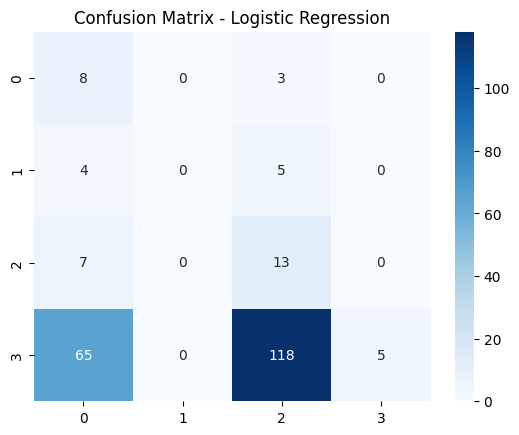

XGBoost Accuracy: 0.39473684210526316


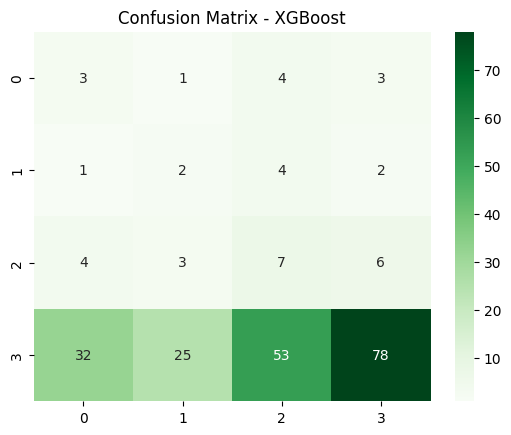

Predicted result: H


In [8]:
# Baseline model: Logistic Regression
lr = LogisticRegression(multi_class='multinomial', max_iter=1000)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))
sns.heatmap(confusion_matrix(y_test, y_pred_lr), annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

# %%
# Advanced model: XGBoost
xgb_model = xgb.XGBClassifier(objective='multi:softmax', num_class=3, eval_metric='mlogloss')
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))
sns.heatmap(confusion_matrix(y_test, y_pred_xgb), annot=True, fmt="d", cmap="Greens")
plt.title("Confusion Matrix - XGBoost")
plt.show()

# %%
# Example prediction for a new match
new_match = pd.DataFrame({
    'home_team_avg_goals_scored':[1.5],
    'home_team_avg_goals_conceded':[1.0],
    'away_team_avg_goals_scored':[1.2],
    'away_team_avg_goals_conceded':[1.3]
})
pred_label = xgb_model.predict(new_match)[0]
pred_result = le_result.inverse_transform([pred_label])[0]
print("Predicted result:", pred_result)